In [1]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import fsolve,least_squares,root

import sys, os
import pickle

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo

import ModelFramework as mf
import ModelFramework.Elements as ele
import ModelFramework.ExternalForces as ef
import FwtModels.RectWing as rw
import FwtModels.RollRig as RollRig
import multiprocessing as mp
from multiprocessing import set_start_method
#set_start_method("spawn")

from matplotlib.lines import Line2D

me.mechanics_printing()

In [2]:
# Add fixed params to dict

main_panels = 20
params = {}
params['c'] = 0.067
params['alpha_r'] = 0
params['c_d_max'] = 1
params['Lambda'] = np.deg2rad(0)
params['alpha_c'] = np.deg2rad(0)
params['p'] = 1
params['sigma'] = 0

In [3]:
# create lift distribution
def create_lift_dist_from_file(filename,span,sigma,main_panels):
    s_w = span*(1-sigma)
    delta = s_w / main_panels
    y_panel = np.linspace(-s_w/2+delta/2,s_w/2-delta/2,main_panels)

    ## load lift distribution
    df = pd.read_csv(filename)
    y_span = df['y'].to_numpy()/df['span']*span*100
    y_c_l = df['C_l'].to_numpy()

    # interpolate on each panel
    return list(np.interp(np.abs(y_panel),y_span,y_c_l,left=0,right=0))

def create_const_lift_dist(main_panels):   
    return [np.pi*2]*main_panels

In [4]:
# create configs
configs = []
locked_params = {}
locked_params['m_w'] = 0.884
locked_params['I_xx_w'] = 0.03978611
locked_params['y_w'] = 0.00047
locked_params['z_w'] = 0.00238
locked_params['s'] = 1
locked_params['a'] = create_lift_dist_from_file(r'LiftDistribution_aoa_0_rr_60_span_100.csv',
                                                locked_params['s'],params['sigma'],main_panels)
configs.append(({'Mode':'Locked','LiftDist':'Roll60'},locked_params))

locked_params = {}
locked_params['m_w'] = 0.884
locked_params['I_xx_w'] = 0.03978611
locked_params['y_w'] = 0.00047
locked_params['z_w'] = 0.00238
locked_params['s'] = 1
locked_params['a'] = create_const_lift_dist(main_panels)
configs.append(({'Mode':'Locked','LiftDist':'Const'},locked_params))

removed_params = {}
removed_params['m_w'] = 0.735
removed_params['I_xx_w'] = 0.014820479
removed_params['y_w'] = 0.0020145
removed_params['z_w'] = 0.002775
removed_params['s'] = 0.728
removed_params['a'] = create_lift_dist_from_file(r'LiftDistribution_aoa_0_rr_60_span_73.csv',
                                                 removed_params['s'],params['sigma'],main_panels)
configs.append(({'Mode':'Removed','LiftDist':'Roll60'},removed_params))

removed_params = {}
removed_params['m_w'] = 0.735
removed_params['I_xx_w'] = 0.014820479
removed_params['y_w'] = 0.0020145
removed_params['z_w'] = 0.002775
removed_params['s'] = 0.728
removed_params['a'] = create_const_lift_dist(main_panels)
configs.append(({'Mode':'Removed','LiftDist':'Const'},removed_params))

In [5]:
# create Jobs
attitudes=[]
vs = [15,20,25,30]
T = [0.06,0.12]
for time_const in T: 
    for v in vs:
        aas = [7,14,21]
        offset = [-0.08,-0.05,0.05]
        for i,tm in enumerate([1.05,1.48,1.75]):
            beta = (tm)*8.4e-4*v**2+offset[i]
            attitudes.append(({"AileronAngle":aas[i],},{"V":v,"beta":beta,"T":time_const}))
jobs=[({**config,**att},{**params,**config_params,**att_params}) for config,config_params in configs for att,att_params in attitudes]

In [6]:
len(jobs)

In [7]:
%%time
j_i = 10
job = jobs[j_i]
ic = [0,0]

p = RollRig.base_params(1,panels=20)
p_vars = vars(p)
for string, value in job[1].items():
    if string in p_vars:
        p_vars[string].value = value
p.V.value = 22
sm = mf.SymbolicModel.from_file('RollRigModel-Fixed.py')
nm = mf.NumericModel.from_SymbolicModel(p,sm)

CPU times: user 236 ms, sys: 3.36 ms, total: 239 ms
Wall time: 239 ms


In [8]:
nm.deriv(0,[1.57,0],p.GetNumericTuple(None,0))

0.0
15.52


0        0.00
1        0.01
2        0.02
3        0.03
4        0.04
        ...  
1548    15.48
1549    15.49
1550    15.50
1551    15.51
1552    15.52
Name: t, Length: 1553, dtype: float64

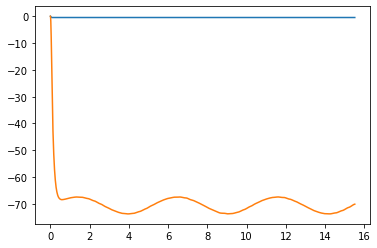

In [9]:
names = ['Roll','Roll Rate','Left FWT Angle','Left FWT Velocity','Right FWT Angle','Right FWT Velocity']
#GenRunData('tempModel.py',3,[0]*p.qs*2,10,{**params,**jobs[0]},names,{'Mode':'Free'},100)[100]
# data = RollRig.GenRunData_StepTorque('RollRigModel-Fixed.py',1,[0,0],10,jobs[0][1],main_panels,names[:2],{**jobs[0][0],**{n:0 for n in names[2:]}},100)
job = jobs[6]
def stop_event(t,y):
    if t<=10:
        return 1
    else:
        return np.deg2rad(360*3+5) - abs(y[0])
stop_event.terminal = True


data = RollRig.GenRunData_StepTorque('RollRigModel-Fixed.py',1,[0,0],30,params=job[1],
                                     panels=main_panels,
                                     calc_coast=False,
                                     xNames=names,
                                     additional_cols={**job[0]},
                                     sample_freq=100,
                                    events = [stop_event])


df = pd.DataFrame(data)
plt.plot(df['t'],df['torque'])
plt.plot(df['t'],np.rad2deg(df['Roll Rate']))
# print(np.rad2deg(df[df['t']>4]['Roll Rate'].mean()))
# {**jobs[0][0],**jobs[0][1]}
print(np.rad2deg(df['Roll'].max()))
print(df['t'].max())
df['t']

# plt.plot(np.rad2deg(df['Roll Rate']),np.gradient(np.rad2deg(df['Roll Rate'])))

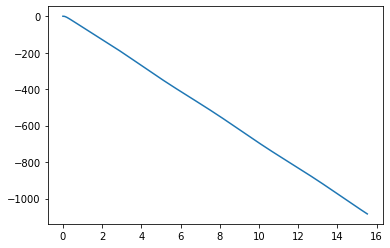

In [10]:
plt.plot(df['t'],np.rad2deg(df['Roll']))


In [19]:
%%time
# for each job edit the parameters and pool it 
pool = mp.Pool(mp.cpu_count())
names = ['Roll','Roll Rate','Left FWT Angle','Left FWT Velocity','Right FWT Angle','Right FWT Velocity']

def stop_event(t,y):
    if t<=10:
        return 1
    else:
        return np.deg2rad(360*3+5) - abs(y[0])
stop_event.terminal = True


res=[]
ls = []
for job in jobs:
    ls += RollRig.GenRunData_StepTorque('RollRigModel-Fixed.py',1,[0,0],30,params=job[1],
                                     panels=main_panels,
                                     calc_coast=False,
                                     xNames=names[:2],
                                     additional_cols={**job[0],**{n:0 for n in names[2:]}},
                                     sample_freq=100,
                                    events = [stop_event])
#     res.append(pool.apply_async(RollRig.GenRunData_StepTorque, args = ('RollRigModel-Fixed.py',1,[0]*2,60,job[1],
#                                                                        main_panels,False,names[:2],
#                                                                        {**job[0],**{n:0 for n in names[2:]}},500,[stop_event])))
# pool.close()
# pool.join()

# ls = []
# for i in res:
#     ls += i.get()
df = pd.DataFrame(ls)
df.to_pickle('FixedData.pkl')

CPU times: user 19.9 s, sys: 4.93 s, total: 24.8 s
Wall time: 24.4 s


In [20]:
df['Roll Rate [Deg]']=np.rad2deg(df['Roll Rate'])
df[df['t']>4].groupby(['Mode','V','AileronAngle'])['Roll Rate [Deg]'].mean()

Mode     V   AileronAngle
Locked   15  7               -24.755581
             14              -47.823849
             21              -78.416846
         20  7               -42.588639
             14              -69.251361
             21              -99.020747
         25  7               -58.555553
             14              -89.542381
             21             -123.526790
         30  7               -73.526567
             14             -112.205165
             21             -146.734009
Removed  15  7               -64.955391
             14             -133.243571
             21             -223.091642
         20  7              -117.321413
             14             -196.884439
             21             -281.443461
         25  7              -165.724491
             14             -256.055488
             21             -341.322406
         30  7              -209.541272
             14             -313.900884
             21             -403.441314
Name: Roll Rat

In [21]:
df.to_csv(r'/Users/fintan/Git/FlexiFWT_DAQ/Analysis/RollingRigV3/ModelComparisonV2/FixedData.csv', index = False)

In [17]:
{n:0 for n in names[2:]}

{'Left FWT Angle': 0,
 'Left FWT Velocity': 0,
 'Right FWT Angle': 0,
 'Right FWT Velocity': 0}